# Apply Models to fit the data

## Import Libraries

In [ ]:
# Install Libraries in the environment
!pip install pandas
!pip install numpy
#!pip install numpy pandas (it is the same)
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Import Machine Learning methods and classes from sklearn library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# sklearn metrics for visualization and assessment of models
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# Different models to test
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Load data from where I was before

In [ ]:
# Work with Files in the OS Folders
import os

# List the documents and folders in the URL indicated
for dirname, _, filenames in os.walk('/content/.config/ProjectTweets.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Import Google drive to the notebook machine
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the labeled and lemmatized dataset
#df = pd.read_csv('/content/drive/MyDrive/ProjectTweets(2).csv')

fields = ['lemmatized_text2', 'sentiment_score_Vader', 'sentiment_class_Vader','week_of_year']

df = pd.read_csv('/content/drive/MyDrive/ProjectTweets(2).csv', usecols=fields, low_memory = True)

# Encode categories in a boolean column, (In order to plot ROC Curves)
# Define the bin edges and labels for two classes
bin_edges = [-1, 0, 1]
class_labels = [0, 1]
df['sentiment_class_Vader'] = pd.cut(df['sentiment_score_Vader'], bins=bin_edges, labels=class_labels)
df.head()

,week_of_year,lemmatized_text2,sentiment_score_Vader,sentiment_class_Vader
0,14,aww bummer shoulda got david carr third day,-0.20,0
1,14,upset update facebook texting might cry result...,-0.75,0
2,14,dived many time ball managed save rest go bound,0.49,1
3,14,whole body feel itchy like fire,-0.25,0
4,14,behaving mad see,-0.66,0


In [ ]:
# select only the data for the first week
df = df[df['week_of_year'].isin([14, 15])]
df.shape

(45458, 4)

## Transforming the Dataset Using Count vectorization

Transforms text into a sparse matrix of n-gram counts.

In [ ]:
list_tweets = list(df['lemmatized_text2'].values.astype('U'))
sentiment = df['sentiment_class_Vader'].values

# define max features: each instance (text) will have this number of features (atributes), that can range from 10000 to 5000000 different words
max_features=10000

In [ ]:
%%time

count_vector=CountVectorizer(max_features=max_features,ngram_range=(1, 2)) # stop_words="english" , ngram_range=(1, 2)

matrix_tweets_cv = count_vector.fit_transform(list_tweets)

# getting the words
all_words = count_vector.get_feature_names_out()

# visualize first 50 words
print("First 50 words: ",all_words[0:50])
print(matrix_tweets_cv.shape)

First 50 words:  ['aa' 'aah' 'aahh' 'aand' 'aargh' 'aaron' 'aaww' 'ab' 'abandoned' 'abit'
 'able' 'able find' 'able get' 'able go' 'able help' 'able make'
 'able sleep' 'able take' 'abruzzo' 'absolute' 'absolutely' 'abt' 'ac'
 'accent' 'accept' 'accepted' 'access' 'accessing' 'accident'
 'accidentally' 'according' 'account' 'accountant' 'accounting' 'accurate'
 'ace' 'ace last' 'ache' 'achievement' 'aching' 'ack' 'acknowledge' 'acm'
 'acne' 'across' 'act' 'acting' 'action' 'active' 'activity']
(20643, 10000)
CPU times: user 725 ms, sys: 6.31 ms, total: 732 ms
Wall time: 739 ms


### Transforming the Dataset Using TF-IDF Vectorizer

Performs the TF-IDF transformation from a provided matrix of counts.

Word counts are a good starting point but are very basic. One issue with simple counts is that some words like “the” will appear many times and their large count values will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies. The most popular way of doing this is called TF-IDF. This is an acronym that stands for “Term Frequency – Inverse Document Frequency". It is calculated as so:

<img src="https://miro.medium.com/max/1400/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg" width="500"/>


In [ ]:
%%time
# TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.
vectorizer = TfidfVectorizer(max_features=max_features,ngram_range=(1, 2), decode_error='replace', encoding='utf-8')

matrix_tweets_tf = vectorizer.fit_transform(list_tweets)

# getting the words
all_words = vectorizer.get_feature_names_out()

# visualize first 50 words
print("First 50 words: ",all_words[0:50])
print(matrix_tweets_tf.shape)

First 50 words:  ['aa' 'aah' 'aahh' 'aand' 'aaron' 'aaw' 'aaww' 'ab' 'abandoned' 'abby'
 'abc' 'ability' 'abit' 'able' 'able get' 'able go' 'able make' 'able see'
 'able sleep' 'able take' 'abroad' 'absolute' 'absolutely' 'absolutly'
 'abt' 'abundance' 'ac' 'academy' 'accent' 'accept' 'accepted' 'access'
 'accident' 'accidentally' 'accidently' 'accomplished' 'according'
 'account' 'accounting' 'acct' 'accurate' 'ace' 'ache' 'achievement'
 'aching' 'ack' 'acoustic' 'across' 'act' 'acting']
(45458, 10000)
CPU times: user 2.29 s, sys: 58.5 ms, total: 2.35 s
Wall time: 4.33 s


In [ ]:
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

No. of feature_words:  10000


In [ ]:
# matrix has 20k x 10k cells, so I print just a tiny slice:
matrix_tweets_tf.toarray()[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
print(vectorizer.vocabulary_)

{'aww': 437, 'bummer': 930, 'shoulda': 7425, 'got': 3466, 'david': 1787, 'third': 8550, 'day': 1791, 'upset': 9232, 'update': 9214, 'facebook': 2668, 'texting': 8411, 'might': 5316, 'cry': 1708, 'result': 7028, 'school': 7222, 'today': 8718, 'also': 173, 'blah': 730, 'update facebook': 9215, 'school today': 7234, 'today also': 8721, 'many': 5143, 'time': 8622, 'ball': 533, 'managed': 5129, 'save': 7197, 'rest': 7020, 'go': 3271, 'bound': 828, 'many time': 5147, 'whole': 9614, 'body': 784, 'feel': 2743, 'itchy': 4231, 'like': 4631, 'fire': 2852, 'mad': 5058, 'see': 7280, 'crew': 1690, 'need': 5739, 'hug': 4015, 'need hug': 5764, 'hey': 3820, 'long': 4806, 'yes': 9936, 'rain': 6792, 'bit': 712, 'lol': 4766, 'fine': 2839, 'thanks': 8429, 'long time': 4813, 'time see': 8647, 'bit lol': 715, 'fine thanks': 2840, 'nope': 6035, 'que': 6717, 'spring': 7788, 'break': 852, 'plain': 6467, 'city': 1257, 'snowing': 7603, 'spring break': 7789, 'ear': 2279, 'bear': 581, 'watch': 9448, 'thought': 8562

## Splitting the Data Into Train and Test Subsets

Divide the  newly generated vectorial representation (matrix) into train and test sets

In [ ]:
%%time
# Sample data (X: features, y: target)
# This doesnt work, because the model requires a sparse matrix as input:
# X, y = df['lemmatized_text2'], df['sentiment_class_Vader']

#  sparse matrix as input and numeric vector as target:
X, y = matrix_tweets_tf.toarray(), df['sentiment_class_Vader'].values

# Step 1: Split the data into a temporary train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26105111) #, stratify = y)  #stratify preserves the original proportion of labels of the original dataset

# Print the sizes of the resulting sets
print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 36366
Test set size: 9092
CPU times: user 549 ms, sys: 2.34 s, total: 2.88 s
Wall time: 4.78 s


In [ ]:
# Separate data for validation of hyperparameters
# Step 2: Further split the train set into a train set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=26105111)

# The sizes are typically chosen as percentages of the original dataset:
# - Test set: 20% of the original data
# - Train set: 60% (or 70%) of the original data
# - Validation set: 20% (or 10%) of the original data. This data is used to tune hyperparameters

# Print the sizes of the resulting sets
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Train set size: 12385
Validation set size: 4129
Test set size: 4129


## **Function for Model Evaluation**

After training the model, I will apply the evaluation measures to check how the model is performing. Accordingly, I use the following evaluation parameters to check the performance of the models respectively:



*  Accuracy Score
*  Confusion Matrix with Plot
*  ROC-AUC Curve

In [ ]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Negative','False Positive', 'False Negative','True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]Vectorizer
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot= labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories) #annot = labels
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.show()

    # Calculate the ROC curve and plot it
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

    return y_pred

In defining the problem, I used five different models, respectively:

**Bernoulli Naive Bayes Classifier**

**SVM (Support Vector Machine)**

**Logistic Regression**

**Linear Support Vector Classificatio (LinearSVC)**

**Classification using Ensemble (RandomForestClassifier)**

The idea behind choosing these models is to test all the classifiers in the dataset, from the simplest to the complex models, and then I will try to find the one that offers the best performance among them.

### **Model 1 Bernoulli Naive Bayes Classifier**

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4575
           1       0.87      0.79      0.83      4517

    accuracy                           0.84      9092
   macro avg       0.84      0.84      0.84      9092
weighted avg       0.84      0.84      0.84      9092



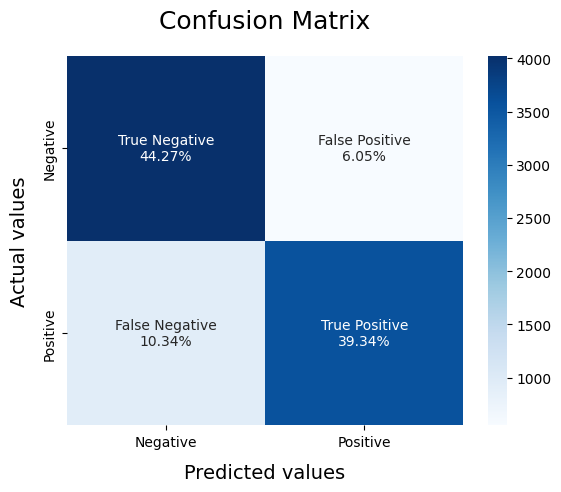

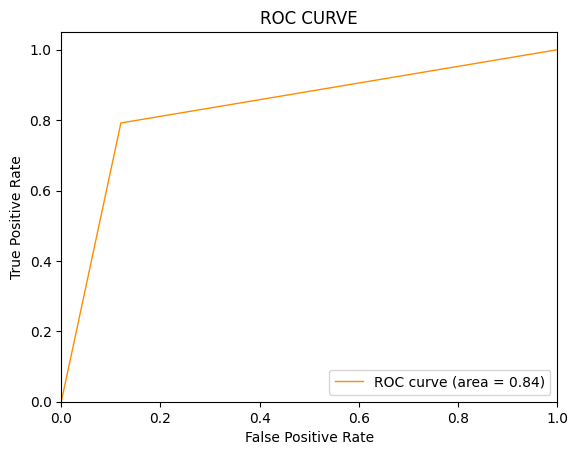

CPU times: user 5.18 s, sys: 1.94 s, total: 7.12 s
Wall time: 6.07 s


In [ ]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
y_pred1 = model_Evaluate(BNBmodel)

#### Alternative implementation of TFIDF vectorizer

In this implementation, we use the encoding in Negative, Positive and Neutral values. It reflects better the usefulness of Vader, and the characteristic neutrality of most tweets. It is a multiclass output that is not possible to compare using one ROC curve. It may be necessary to plot 3 ROC curves and the interpretation is ambiguous.

In [ ]:
# Load the labeled and lemmatized dataset
#df = pd.read_csv('/content/drive/MyDrive/Nurse Salaries Project/ProjectTweets(2).csv')

fields = ['lemmatized_text2', 'sentiment_score_Vader', 'sentiment_class_Vader','week_of_year']

df = pd.read_csv('/content/drive/MyDrive/Nurse Salaries Project/ProjectTweets(2).csv', usecols=fields, low_memory = True)

# encode the categories in numeric values (three values)
df['sentiment_class_Vader'].replace(['Negative', 'Neutral', 'Positive'], [-1, 0, 1], inplace=True)
df.head()

,week_of_year,lemmatized_text2,sentiment_score_Vader,sentiment_class_Vader
0,14,aww bummer shoulda got david carr third day,-0.20,-1.0
1,14,upset update facebook texting might cry result...,-0.75,-1.0
2,14,dived many time ball managed save rest go bound,0.49,1.0
3,14,whole body feel itchy like fire,-0.25,-1.0
4,14,behaving mad see,-0.66,-1.0


In [ ]:
df = df[df['week_of_year']==14]

In [ ]:
list_tweets = list(df['lemmatized_text2'].values.astype('U'))
sentiment = df['sentiment_class_Vader'].values

In [ ]:
# split data into Train Test sets
train_x, test_x, train_y, test_y = train_test_split(list_tweets, sentiment, test_size = 0.2, random_state = 0)
print(f'Data Split done.')
print(f"Train set size: {len(train_x)}")
print(f"Test set size: {len(test_x)}")

Data Split done.
Train set size: 16514
Test set size: 4129


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
vectoriser.fit(train_x)
print(f'Vectorizer fitted')
print('No. of feature_words: ',len(vectoriser.get_feature_names_out()))

Vectorizer fitted
No. of feature_words:  5000


In [ ]:
%%time
X_train_v = vectoriser.transform(train_x)
X_test_v  = vectoriser.transform(test_x)
print(type(X_train_v), X_train_v.shape)
print(type(X_test_v), X_test_v.shape)

<class 'scipy.sparse._csr.csr_matrix'> (16514, 5000)
<class 'scipy.sparse._csr.csr_matrix'> (4129, 5000)
CPU times: user 461 ms, sys: 3.17 ms, total: 464 ms
Wall time: 476 ms


              precision    recall  f1-score   support

        -1.0       0.72      0.59      0.65       993
         0.0       0.73      0.83      0.78      1206
         1.0       0.84      0.84      0.84      1930

    accuracy                           0.78      4129
   macro avg       0.76      0.75      0.75      4129
weighted avg       0.78      0.78      0.78      4129



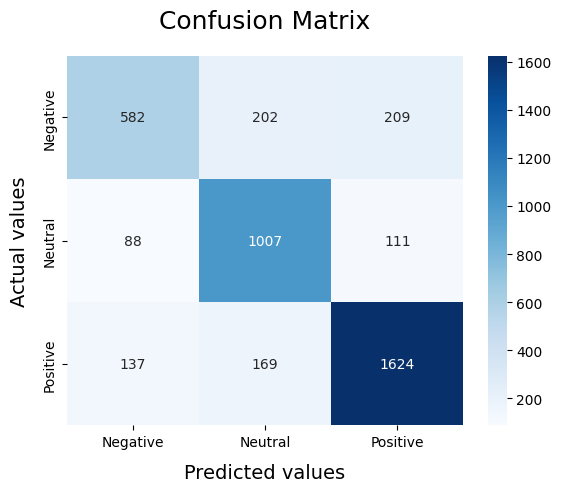

CPU times: user 265 ms, sys: 105 ms, total: 370 ms
Wall time: 251 ms


In [ ]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_v, train_y)

y_pred = BNBmodel.predict(X_test_v)

# Print the evaluation metrics for the dataset.
print(classification_report(test_y, y_pred))

# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(test_y, y_pred)
categories = ['Negative', 'Neutral', 'Positive']
group_names = ['True Negative','False Positive', 'False Negative','True Positive']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
#labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
#labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=True, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

### **Model 2 SVM (Support Vector Machine)**

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4575
           1       0.89      0.84      0.87      4517

    accuracy                           0.87      9092
   macro avg       0.87      0.87      0.87      9092
weighted avg       0.87      0.87      0.87      9092



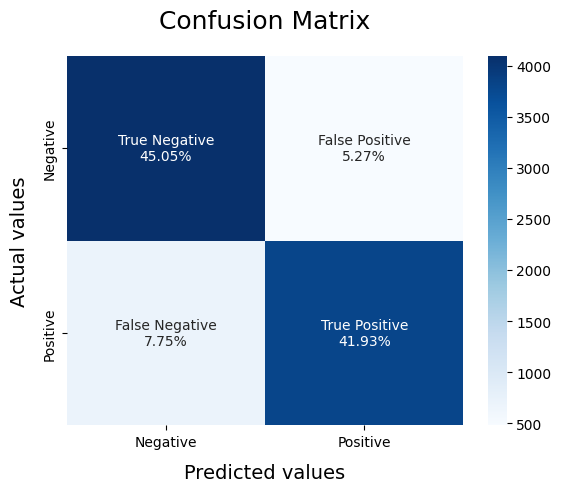

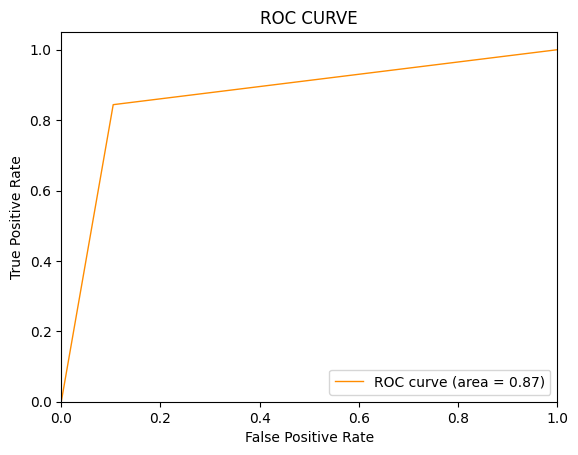

CPU times: user 2.56 s, sys: 289 ms, total: 2.85 s
Wall time: 2.51 s


In [ ]:
%%time
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_pred2 = model_Evaluate(SVCmodel)

### **Model 3 Logistic Regression**

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      4575
           1       0.89      0.84      0.87      4517

    accuracy                           0.87      9092
   macro avg       0.87      0.87      0.87      9092
weighted avg       0.87      0.87      0.87      9092



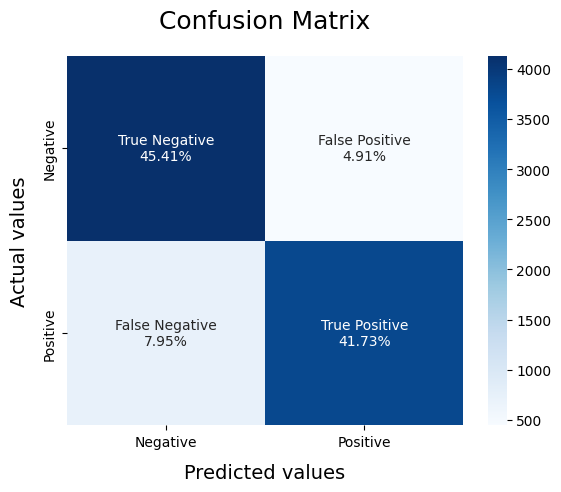

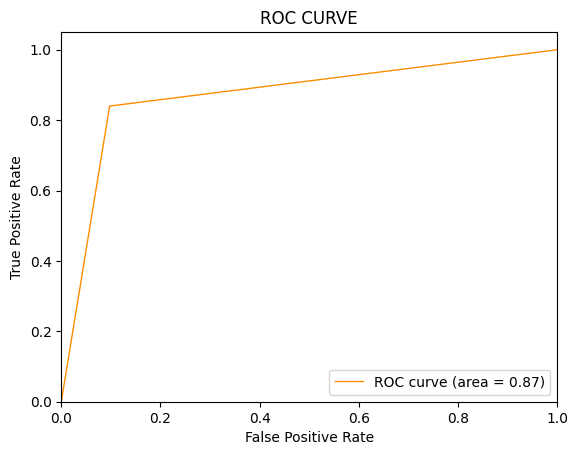

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred3 = model_Evaluate(LRmodel)

### **Model 4 Linear Support Vector Classification (LinearSVC)**

In [ ]:
'''
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
 '''
 # do I have to load the sets diferently???

In [ ]:
%%time
from sklearn.svm import SVC
clf=SVC()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
test_acc_svc=accuracy_score(y_test,y_pred)
print(test_acc_svc)
cfm=confusion_matrix(y_test,y_pred)
print(cfm)

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cfm, annot=True, fmt='d', linewidths=0.5, cmap='winter', cbar=True, annot_kws={"size": 12})

# Add axis labels
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc_svc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, color='navy', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_svc)

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='skyblue', lw=1, linestyle='--')

# Customize grid lines
plt.grid(color='gray', linestyle='--', linewidth=0.5)



plt.show()

### **Model 5 Classification using Ensemble (RandomForestClassifier)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(X_train, y_train)
yr_pred = random_forest_classifier.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix
test_acc_rfc=accuracy_score(y_test,yr_pred)
print(test_acc_rfc)
rf_cfm=confusion_matrix(y_test,yr_pred)
print(rf_cfm)

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(rf_cfm, annot=True, fmt='', linewidths=0.5, cmap='winter', cbar=True, annot_kws={"size": 12})

# Add axis labels
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_rfc, tpr_rfc, thresholds = roc_curve(y_test, yr_pred)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr_rfc, tpr_rfc, color='navy', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc_rfc)

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='skyblue', lw=1, linestyle='--')

# Customize grid lines
plt.grid(color='gray', linestyle='--', linewidth=0.5)



plt.show()

In [ ]:
# Create a bar chart to compare accuracy
models = ['SVC', 'RFC']
accuracies = [test_acc_svc, test_acc_rfc]

plt.bar(models, accuracies, color=['lightblue', 'lightgreen'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for accuracy
# Annotate the bars with accuracy values
for i, v in enumerate(accuracies):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

In [ ]:
# Create a ROC curve comparison plot
plt.figure(figsize=(8, 6))
plt.plot('fpr', 'tpr', color='darkorange', lw=2, label=f'SVC (AUC = {roc_auc_svc:.2f})')
plt.plot(fpr_rfc, tpr_rfc, color='navy', lw=1.6, label=f'RFC (AUC = {roc_auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
import joblib

# Save the model to a file
joblib.dump('clf', 'trained_model_svc.pkl')

In [ ]:
joblib.dump('random_forest_classifier','trained_model_rfc.pkl')

In [ ]:
!ls

drive  sample_data


# Time Series Analysis of Sentiment change

Analyze any change in sentiment that ocurs over the time period detailed

Make a time series forecast of the sentiment of the entire dataset at 1 week , 1 month and 3 months going forward. Use at least two methods

the forecast must be displayed as a dynamic dashboard

Hint: This is a Short Time series

## User Engagement Analysis:

- Scatter Plot: Plot user engagement metrics (e.g., retweets, favorites) against user follower counts to analyze user influence.
- Network Graph: Visualize the network of interactions between users, including mentions and retweets.

Topic Modeling:

    Stacked Area Chart: Visualize the distribution of topics over time using a stacked area chart.
    Treemap: Use a treemap to display the hierarchy of topics and subtopics.

Word Embeddings:

    t-SNE or UMAP Plot: Visualize word embeddings using t-SNE or UMAP to cluster similar words.

Correlation Analysis:

    Heatmap: Create a heatmap to visualize correlations between numerical variables, such as the number of retweets and favorites.

Comparison Analysis:

    Box Plot or Violin Plot: Compare tweet statistics, such as tweet lengths, between different groups, e.g., comparing tweets with positive and negative sentiment.

Community Detection:

    Network Graph: Detect and visualize communities within the user interaction network.

Language Analysis:

    Pie Chart: Display the distribution of languages used in the tweets.

Text Analysis:

    Term Frequency-Inverse Document Frequency (TF-IDF) Plot: Visualize the importance of words in the tweets.

Time Series Forecasting:

    Line Plot: Plot the actual and forecasted tweet counts using time series forecasting models.

Emoticon Analysis:

    Scatter Plot or Bubble Chart: Visualize the use of emoticons in tweets.

##**Conclusion**

Through this project, I understood how Sentiment Analysis is used to understand public emotions behind tweets. Using the codes and information I got during this project, I was able to see and understand that Twitter Sentiment Analysis helps us to pre-process data (tweets) using different methods and feed it into ML models to provide the best accuracy.

# Code Reuse to be put in the right place

In [ ]:
# Install libraries for Tensor Computation with GPU acceleration for Deep Neural Networks
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.7 MB/s eta 0:00:00


In [ ]:
# some external packages
!pip install pyspellchecker
!pip install pyspark
!pip install findspark

In [ ]:
# Import Neural Networks libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers